# Bibliotecas

In [3]:

# Importação de Bibliotecas

from datetime import datetime
# Bibliotecas padrão

# Bibliotecas de visualização
import matplotlib.pyplot as plt  # Biblioteca para criar gráficos e visualizações.

# Gymnasium - Framework para criação de ambientes de simulação
import gymnasium as gym  # Criação de ambientes de aprendizado por reforço.
from gymnasium import spaces  # Espaços de ação e observação em ambientes Gymnasium.
from stable_baselines3 import PPO  # Importação do algoritmo Proximal Policy Optimization (PPO), usado em aprendizado por reforço para treinar agentes.


from stable_baselines3.common.callbacks import BaseCallback

from Env_utils.Env_util import *
from Topology import Paloalto
from SFC_utils.Sfc_util import *

# Função de Plotagem de Gráfico

In [6]:
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from datetime import datetime

class RewardTrackingCallback(BaseCallback):
    """
    Callback para armazenar e visualizar a evolução das recompensas ao longo do treinamento.
    Ele registra a soma das recompensas por episódio e faz um gráfico de recompensas médias por intervalo.
    """

    def __init__(self, log_interval_episodes=10):
        super().__init__()
        self.rewards = []  # Lista das recompensas médias registradas
        self.episode_rewards = []  # Armazena as recompensas totais de cada episódio
        self.log_interval_episodes = log_interval_episodes  # Intervalo para registro
        self.cumulative_reward = 0  # Acumula recompensa dentro do episódio
        self.episode_count = 0  # Contador de episódios

    def _on_step(self) -> bool:
        """
        Acumula a recompensa do episódio e registra quando termina.
        """
        reward = sum(self.locals["rewards"])  # Soma todas as recompensas (suporta múltiplos ambientes)
        done = self.locals["dones"][0]  # Verifica se o episódio terminou

        self.cumulative_reward += reward

        if done:
            self.episode_count += 1
            self.episode_rewards.append(self.cumulative_reward)
            self.cumulative_reward = 0  # Reset para o próximo episódio

            # Registra um ponto no gráfico a cada 'log_interval_episodes' episódios
            if self.episode_count % self.log_interval_episodes == 0:
                avg_reward = np.mean(self.episode_rewards[-self.log_interval_episodes:])
                self.rewards.append(avg_reward)

        return True

    def plot_rewards(self):
        """
        Plota a evolução das recompensas ao longo do treinamento.
        """
        if not self.rewards:
            print("Nenhuma recompensa registrada para plotagem.")
            return
        
        plt.figure(figsize=(12, 6))

        # Criando um eixo X proporcional ao número de episódios
        x_values = np.arange(self.log_interval_episodes, 
                             len(self.rewards) * self.log_interval_episodes + 1, 
                             self.log_interval_episodes)

        # Suavizando a curva com uma média móvel
        window_size = max(1, len(self.rewards) // 10)  # Janela de suavização
        rolling_avg = np.convolve(self.rewards, np.ones(window_size)/window_size, mode='valid')

        # Plota a linha de recompensa original com transparência
        plt.plot(x_values[:len(rolling_avg)], rolling_avg, label="Média Móvel da Recompensa", color='b')
        plt.scatter(x_values, self.rewards, label="Recompensa Média", alpha=0.4, color='gray')

        plt.xlabel("Episódios")
        plt.ylabel("Recompensa Média")
        plt.title("Evolução da Recompensa Durante o Treinamento")
        plt.legend()
        plt.grid(True)
        
        # Formatação do eixo X para exibir milhares (ex: 10k ao invés de 10000)
        plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1000)}k' if x >= 1000 else f'{int(x)}'))

        # Limite automático do eixo Y para evitar distorções
        plt.ylim(min(self.rewards) - 10, max(self.rewards) + 10)

        # Salvar gráfico com timestamp para evitar sobrescrita
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        path = f"/home/lacis/Downloads/Proj laboratorio/SFC_Reinf_Learning/Graficos_Recompensa/Grafico_{timestamp}.png"
        
        plt.savefig(path)
        plt.show()


In [7]:
from stable_baselines3.common.env_checker import check_env

network_topology = Paloalto.create_network_topology()
G = Paloalto.initialize_graph(network_topology)
# Criação do ambiente
env = NetworkEnv(
    num_nodes=37,
    graph=G,
    List_sessions_sfc=generate_list_sessions(G), num_scenarios=10
)

# Verifica a conformidade do ambiente
check_env(env, warn=True)


# Criação e Treinamento do Modelo

In [8]:
sfc_model = generate_random_sfc()
print(sfc_model)

{'s0': {'cpu': 22, 'cache': 24, 'bandwidth_output': 22, 'shareable': True}, 's1': {'cpu': 22, 'cache': 29, 'bandwidth_output': 27, 'shareable': False}, 's2': {'cpu': 16, 'cache': 15, 'bandwidth_output': 28, 'shareable': True}, 's3': {'cpu': 26, 'cache': 29, 'bandwidth_output': 23, 'shareable': False}, 's4': {'cpu': 0, 'cache': 0, 'bandwidth_output': 0, 'shareable': False}}


In [9]:
from SFC_utils.Sfc_util import generate_list_sessions

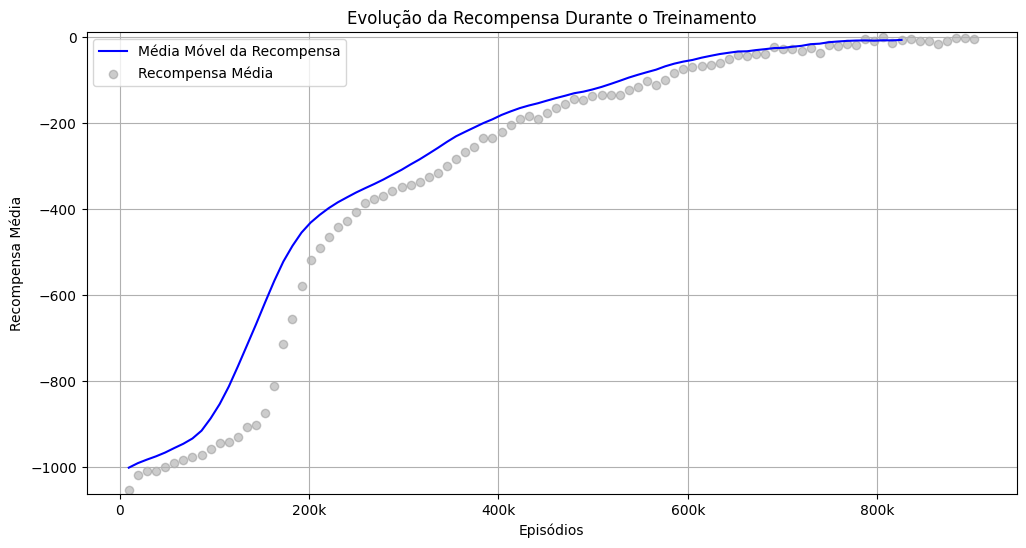

In [ ]:

# Geração dos requisitos das SFCs
num_sfcs = 8


list_sessions = generate_list_sessions(G,4,4)



# Número de nós na rede
num_nodes = len(network_topology)

# Inicialização do ambiente
env = NetworkEnv(num_nodes=num_nodes, graph=G, List_sessions_sfc=list_sessions, 
                 pesos={"cpu": 1.0, "cache": 1.0, "bandwidth": 1.0}, num_scenarios=25000)

# Criar callback para rastrear recompensas

episodios_log = 60*8
reward_callback = RewardTrackingCallback(log_interval_episodes=(episodios_log*20))

# Treinamento do modelo
model = PPO("MlpPolicy", env, verbose=0, learning_rate=0.0003, batch_size=64, n_steps=4096)
model.learn(total_timesteps=int(143000 *episodios_log), callback=reward_callback)
model.save("ppo_sfc_allocation")

# Exibir o gráfico das recompensas acumuladas
reward_callback.plot_rewards()








Modelo carregado com sucesso. Continuando o treinamento...


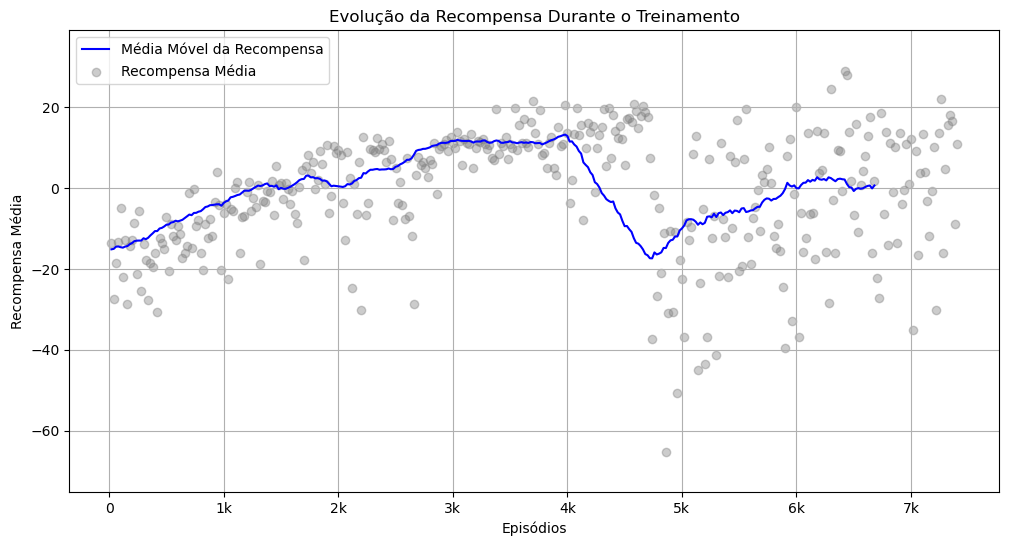

In [12]:

# Número de episódios para continuar treinando
episodios_log = 1
reward_callback = RewardTrackingCallback(log_interval_episodes=(episodios_log*20))

# Carregar modelo salvo
try:
    model = PPO.load("ppo_sfc_allocation", env)  # Carrega o modelo salvo e associa ao ambiente
    print("Modelo carregado com sucesso. Continuando o treinamento...")
except FileNotFoundError:
    print("Modelo não encontrado. Iniciando novo treinamento...")
    model = PPO("MlpPolicy", env, verbose=0, learning_rate=0.0003, batch_size=64, n_steps=4096)

# Continuar o treinamento
model.learn(total_timesteps=int(139750 * episodios_log), callback=reward_callback)

# Salvar novamente após o novo treinamento
model.save("ppo_sfc_allocation")

# Exibir o gráfico das recompensas acumuladas
reward_callback.plot_rewards()


# Teste do Modelo

In [14]:
import time
num_nodes = len(network_topology)
# Carregar o modelo treinado
model = PPO.load("ppo_sfc_allocation")

# Gerar requisitos das SFCs
num_sessions = 4
num_sfcs_per_session = 4
sfc_model = generate_random_sfc()
list_sessions = generate_list_sessions(G, num_sessions, num_sfcs_per_session)

# Inicializar o ambiente
env = NetworkEnv(
    num_nodes=num_nodes, 
    graph=G, 
    List_sessions_sfc=list_sessions, 
    pesos={"cpu": 1.0, "cache": 1.0, "bandwidth": 1.0}, 
    num_scenarios=10
)

# Testar o modelo
num_episodes = 1000*3*2  # Número de episódios para avaliação
total_rewards = []
successes = 0
success_threshold = -125  # Novo critério de sucesso
execution_times = []  # Lista para armazenar os tempos de execução

for episode in range(num_episodes):

    state, _ = env.reset()
    done = False
    episode_reward = 0
    start_time = time.time()  # Tempo de início do episódio

    while not done:
        action, _ = model.predict(state)
        state, reward, done, _, _ = env.step(action)
        episode_reward += reward

    end_time = time.time()  # Tempo de fim do episódio
    execution_times.append(end_time - start_time)  # Armazena tempo do episódio

    total_rewards.append(episode_reward)

    # Critério de sucesso: recompensa >= -50
    if episode_reward >= success_threshold:
        successes += 1

# Cálculo das métricas estatísticas
mean_reward = np.mean(total_rewards)
std_reward = np.std(total_rewards)
success_rate = (successes / num_episodes) * 100
min_reward = np.min(total_rewards)
max_reward = np.max(total_rewards)
q1 = np.percentile(total_rewards, 25)  # Primeiro quartil (Q1)
median = np.percentile(total_rewards, 50)  # Mediana (Q2)
q3 = np.percentile(total_rewards, 75)  # Terceiro quartil (Q3)

# Cálculo do tempo médio de alocação
mean_execution_time = np.mean(execution_times)

# Exibir métricas de desempenho
print("\n===== Avaliação do Modelo PPO =====")
print(f"Número de episódios: {num_episodes}")
print(f"Recompensa média: {mean_reward:.2f}")
print(f"Desvio padrão das recompensas: {std_reward:.2f}")
print(f"Taxa de sucesso (≥ {success_threshold} de recompensa): {success_rate:.2f}%")
print(f"Recompensa mínima: {min_reward:.2f}")
print(f"Primeiro quartil (Q1 - 25%): {q1:.2f}")
print(f"Mediana (Q2 - 50%): {median:.2f}")
print(f"Terceiro quartil (Q3 - 75%): {q3:.2f}")
print(f"Recompensa máxima: {max_reward:.2f}")
print(f"Tempo médio de alocação por episódio: {mean_execution_time:.4f} segundos")
# print(f"Recompensas por episódio: {total_rewards}") 


===== Avaliação do Modelo PPO =====
Número de episódios: 6000
Recompensa média: -260.23
Desvio padrão das recompensas: 430.54
Taxa de sucesso (≥ -125 de recompensa): 60.43%
Recompensa mínima: -879.68
Primeiro quartil (Q1 - 25%): -778.97
Mediana (Q2 - 50%): 33.73
Terceiro quartil (Q3 - 75%): 104.09
Recompensa máxima: 212.92
Tempo médio de alocação por episódio: 0.0129 segundos


# Estado da Rede após Alocação

In [15]:
env.render()

Recursos dos nós:
Nó 0: {'cpu': 100, 'cache': 100, 'reuse': []}
Nó 1: {'cpu': 100, 'cache': 100, 'reuse': []}
Nó 2: {'cpu': 77, 'cache': 79, 'reuse': []}
Nó 3: {'cpu': 100, 'cache': 100, 'reuse': []}
Nó 4: {'cpu': 61, 'cache': 53, 'reuse': ['s2']}
Nó 5: {'cpu': 83, 'cache': 83, 'reuse': ['s3']}
Nó 6: {'cpu': 100, 'cache': 100, 'reuse': []}
Nó 7: {'cpu': 100, 'cache': 100, 'reuse': []}
Nó 8: {'cpu': 61, 'cache': 53, 'reuse': ['s2']}
Nó 9: {'cpu': 100, 'cache': 100, 'reuse': []}
Nó 10: {'cpu': 100, 'cache': 100, 'reuse': []}
Nó 11: {'cpu': 83, 'cache': 83, 'reuse': ['s3']}
Nó 12: {'cpu': 100, 'cache': 100, 'reuse': []}
Nó 13: {'cpu': 100, 'cache': 100, 'reuse': []}
Nó 14: {'cpu': 100, 'cache': 100, 'reuse': []}
Nó 15: {'cpu': 90, 'cache': 77, 'reuse': ['s0']}
Nó 16: {'cpu': 48, 'cache': 46, 'reuse': ['s1']}
Nó 17: {'cpu': 67, 'cache': 56, 'reuse': ['s0']}
Nó 18: {'cpu': 100, 'cache': 100, 'reuse': []}
Nó 19: {'cpu': 100, 'cache': 100, 'reuse': []}
Nó 20: {'cpu': 100, 'cache': 100, 'reuse

# SFCs Alocadas

In [16]:
visualize_sessions(env.Allocated_sessions)

Session ID: 0
SFCs:
SFC ID: 0
  s0: {'cpu': 18, 'cache': 15, 'bandwidth_output': 26, 'shareable': False}
  s1: {'cpu': 16, 'cache': 24, 'bandwidth_output': 11, 'shareable': True}
  s2: {'cpu': 23, 'cache': 23, 'bandwidth_output': 12, 'shareable': True}
  s3: {'cpu': 16, 'cache': 24, 'bandwidth_output': 29, 'shareable': False}
  s4: {'cpu': 0, 'cache': 0, 'bandwidth_output': 0, 'shareable': False}
  Último servidor: 28
----------------------------------------
SFC ID: 1
  s0: {'cpu': 18, 'cache': 15, 'bandwidth_output': 26, 'shareable': False}
  s1: {'cpu': 16, 'cache': 24, 'bandwidth_output': 11, 'shareable': True}
  s2: {'cpu': 23, 'cache': 23, 'bandwidth_output': 12, 'shareable': True}
  s3: {'cpu': 16, 'cache': 24, 'bandwidth_output': 29, 'shareable': False}
  s4: {'cpu': 0, 'cache': 0, 'bandwidth_output': 0, 'shareable': False}
  Último servidor: 4
----------------------------------------
SFC ID: 2
  s0: {'cpu': 18, 'cache': 15, 'bandwidth_output': 26, 'shareable': False}
  s1: {'cp

# Propostas Rotas e recompensas

In [17]:
print(env.proposta_all_sessions)
print(env.totalreward)


print(env.get_routes())

[[[16, 16, 28, 28, 28], [31, 16, 4, 4, 4], [16, 16, 28, 28, 28], [24, 16, 8, 8, 8]], [[34, 16, 25, 34, 34], [35, 16, 25, 35, 35], [17, 16, 25, 17, 17], [15, 16, 25, 2, 2]], [[15, 16, 25, 36, 36], [15, 16, 25, 11, 11], [15, 16, 25, 11, 31], [15, 16, 25, 5, 5]], [[15, 16, 25, 11, 17], [15, 16, 25, 30, 30], [15, 16, 25, 11, 23], [15, 16, 25, 11, 15]]]
100.06548088159596
{'Session_ID0': {'SFC_ID_0': {'Sf_0': [0, 3, 2, 15, 16], 'Sf_1': [16], 'Sf_2': [16, 31, 12, 11, 10, 9, 8, 28], 'Sf_3': [28], 'Sf_4': [28]}, 'SFC_ID_1': {'Sf_0': [0, 3, 2, 15, 16, 31], 'Sf_1': [31, 16], 'Sf_2': [16, 15, 2, 3, 4], 'Sf_3': [4], 'Sf_4': [4]}, 'SFC_ID_2': {'Sf_0': [0, 3, 2, 15, 16], 'Sf_1': [16], 'Sf_2': [16, 31, 12, 11, 10, 9, 8, 28], 'Sf_3': [28], 'Sf_4': [28]}, 'SFC_ID_3': {'Sf_0': [0, 3, 20, 24], 'Sf_1': [24, 25, 16], 'Sf_2': [16, 31, 12, 11, 10, 9, 8], 'Sf_3': [8], 'Sf_4': [8]}}, 'Session_ID1': {'SFC_ID_0': {'Sf_0': [0, 3, 2, 14, 33, 32, 34], 'Sf_1': [34, 32, 31, 16], 'Sf_2': [16, 25], 'Sf_3': [25, 26, 32,